In [528]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from tiny_ta import atr, rsi, sma

# End of the Month - Strategie im S&P 500

Zunächst werden die Kursdaten für den S&P 500 geladen und bereinigt

In [529]:
SYMBOL = "^GSPC"
stock = yf.download(SYMBOL)

stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

[*********************100%%**********************]  1 of 1 completed


Der VIX für die Volatilität wird als externer Indikator mit betrachtet

In [530]:
vix = yf.download("^VIX")
vix["vix"] = vix["Close"]
stock = pd.merge(
    stock,
    vix[
        [
            "vix",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Die 5 jährigen Staatsanleihen werden ebenfalls mit betrachtet

In [531]:
yield_5_years = yf.download("^FVX")

yield_5_years["yield_5yr"] = yield_5_years["Close"]
stock = pd.merge(
    stock,
    yield_5_years[
        [
            "yield_5yr",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Ein paar Indikatoren für spätere Auswertungen

In [532]:
stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["month"] = stock.index.month

Markiere die letzten x Tage und ersten x Tage im Monat für die geplanten Trades. 

In [533]:
days = 5

# Identify end of month
end_of_month = stock.groupby([stock.index.year, stock.index.month]).tail(days)

# Identify beginning of month
beginning_of_month = stock.groupby([stock.index.year, stock.index.month]).head(days)

# add countdown
end_of_month["countdown"] = -1
end_of_month["days"] = end_of_month["countdown"].cumsum().mod(days) + 1
end_of_month["days"] = end_of_month["days"] * -1

beginning_of_month["countdown"] = 1
beginning_of_month["days"] = beginning_of_month["countdown"].cumsum().mod(days)
beginning_of_month.loc[beginning_of_month.days == 0, "days"] = days

# Combine the results
marked_days = pd.concat([end_of_month, beginning_of_month])
marked_days["hold"] = 1

df = pd.merge(
    left=stock,
    right=marked_days[["hold", "days"]],
    left_index=True,
    right_index=True,
    how="left",
)

df.hold = df.hold.fillna(0)

df["buy"] = np.where(
    (df.hold.shift(1) == 0) & (df.hold == 1),
    1,
    np.where((df.hold == 1) & (df.hold.shift(-1) == 0), -1, np.nan),
)

df.hold = np.where(df.hold == 1, df.Low, np.nan)

## Jetzt zur Strategie
Es wird 5 Tage vor Monatsende gekauft und 5 Tage nach Monatsanfang gekauft

In [534]:
from backtesting import Strategy


class end_of_month(Strategy):
    """
    strategy for trend_trading
    """

    days_before = -5
    days_after = 5

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

        self.vix = self.I(lambda: self.data.vix, name="VIX", overlay=False)
        self.yield_5yr = self.I(
            lambda: self.data.yield_5yr, name="Yield 5", overlay=False
        )

        # long signal
        self.hold = self.I(
            lambda: self.data.hold,
            overlay=True,
            name="Hold",
            scatter=True,
            color="green",
        )

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if self.data.days[-1] == self.days_before:
            self.buy()

In [535]:
from backtesting import Backtest

bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-15 00:00:00
Duration                   4486 days 00:00:00
Exposure Time [%]                   47.717708
Equity Final [$]                 198674.97551
Equity Peak [$]                 201392.952155
Return [%]                          98.674976
Buy & Hold Return [%]              296.365057
Return (Ann.) [%]                    5.760248
Volatility (Ann.) [%]               11.267987
Sharpe Ratio                         0.511205
Sortino Ratio                        0.793906
Calmar Ratio                          0.42091
Max. Drawdown [%]                  -13.685236
Avg. Drawdown [%]                   -2.013761
Max. Drawdown Duration     1190 days 00:00:00
Avg. Drawdown Duration       58 days 00:00:00
# Trades                                  148
Win Rate [%]                        60.135135
Best Trade [%]                       8.959772
Worst Trade [%]                    -11.755896
Avg. Trade [%]                    

jetzt wird überprüft welche Tage für die Ein- und Ausstiege besser sein könnten.

In [536]:
stats, heatmap = bt.optimize(
    days_before=range(-5, 0, 1),
    days_after=range(1, 6),
    maximize="Profit Factor",  # "Equity Final [$]",
    max_tries=200,
    random_state=0,
    return_heatmap=True,
)

/Users/produktmanagement/Python/github/backtesting-trading-strategies/.venv/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [537]:
# heatmap
heatmap.sort_values().iloc[-3:]

days_before  days_after
-5           4             1.676500
-4           5             1.683593
-5           5             1.731131
Name: Profit Factor, dtype: float64

In [538]:
heatmap.groupby(["days_before", "days_after"]).mean().unstack()

days_after,1,2,3,4,5
days_before,,,,,
-5,1.307131,1.381908,1.473440,1.676500,1.731131
-4,1.225718,1.294645,1.402072,1.590593,1.683593
-3,1.058314,1.130969,1.245322,1.433901,1.505442
-2,0.838908,0.932885,1.061843,1.254058,1.360443
-1,0.764818,0.894282,1.048646,1.257791,1.346506


In [539]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-15 00:00:00
Duration                   4486 days 00:00:00
Exposure Time [%]                   47.717708
Equity Final [$]                 198674.97551
Equity Peak [$]                 201392.952155
Return [%]                          98.674976
Buy & Hold Return [%]              296.365057
Return (Ann.) [%]                    5.760248
Volatility (Ann.) [%]               11.267987
Sharpe Ratio                         0.511205
Sortino Ratio                        0.793906
Calmar Ratio                          0.42091
Max. Drawdown [%]                  -13.685236
Avg. Drawdown [%]                   -2.013761
Max. Drawdown Duration     1190 days 00:00:00
Avg. Drawdown Duration       58 days 00:00:00
# Trades                                  148
Win Rate [%]                        60.135135
Best Trade [%]                       8.959772
Worst Trade [%]                    -11.755896
Avg. Trade [%]                    

The Winner is ...

In [540]:
stats["_strategy"]

<Strategy end_of_month(days_before=-5,days_after=5)>

In [541]:
# bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run(days_before=-5, days_after=5)
bt.plot(superimpose=False, open_browser=False)

Row(id='88368', ...)

In [542]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-15 00:00:00
Duration                   4486 days 00:00:00
Exposure Time [%]                   47.717708
Equity Final [$]                 198674.97551
Equity Peak [$]                 201392.952155
Return [%]                          98.674976
Buy & Hold Return [%]              296.365057
Return (Ann.) [%]                    5.760248
Volatility (Ann.) [%]               11.267987
Sharpe Ratio                         0.511205
Sortino Ratio                        0.793906
Calmar Ratio                          0.42091
Max. Drawdown [%]                  -13.685236
Avg. Drawdown [%]                   -2.013761
Max. Drawdown Duration     1190 days 00:00:00
Avg. Drawdown Duration       58 days 00:00:00
# Trades                                  148
Win Rate [%]                        60.135135
Best Trade [%]                       8.959772
Worst Trade [%]                    -11.755896
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [543]:
stats["Win Rate [%]"]

60.13513513513513

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [544]:
stats["Avg. Trade [%]"]

0.469014785766797

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [545]:
stats["Profit Factor"]

1.7311305157699906

In [546]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [547]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.05].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0582
2,0.0520
3,-0.1346
4,0.1179
5,-0.0354
6,0.1917
7,0.1663
8,0.0525
9,0.0332


<Axes: title={'center': 'Gewinner Trades'}>

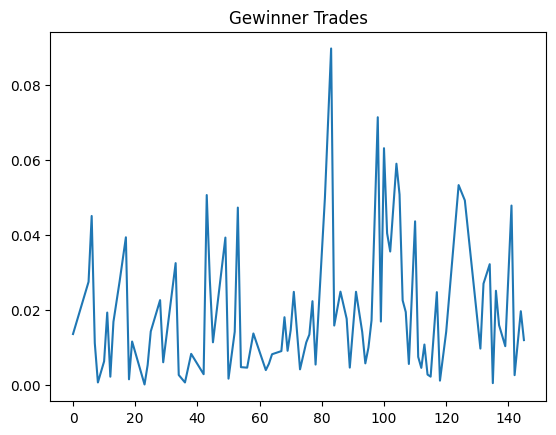

In [548]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

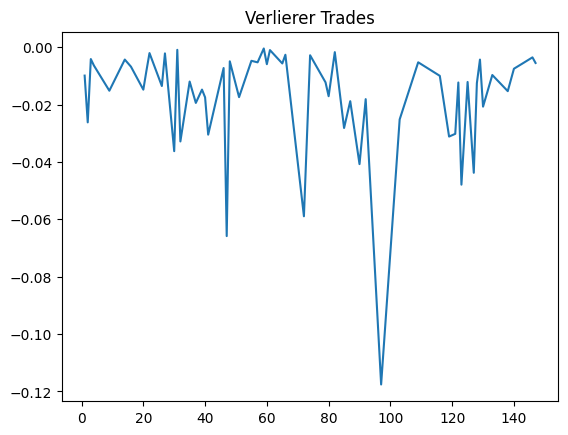

In [549]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [550]:
class end_of_month_and_skip_month(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [551]:
bt = Backtest(
    df["2012-01-01":], end_of_month_and_skip_month, cash=100_000, commission=0.002
)
stats = bt.run(days_before=-5, days_after=5, skip_month=skip_month)
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='89934', ...)

In [552]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-15 00:00:00
Duration                   4486 days 00:00:00
Exposure Time [%]                   27.840725
Equity Final [$]                225158.653937
Equity Peak [$]                 227006.793098
Return [%]                         125.158654
Buy & Hold Return [%]              296.365057
Return (Ann.) [%]                     6.84543
Volatility (Ann.) [%]                8.378259
Sharpe Ratio                         0.817047
Sortino Ratio                        1.377377
Calmar Ratio                         0.576489
Max. Drawdown [%]                  -11.874341
Avg. Drawdown [%]                   -1.785559
Max. Drawdown Duration     1637 days 00:00:00
Avg. Drawdown Duration       62 days 00:00:00
# Trades                                   86
Win Rate [%]                         67.44186
Best Trade [%]                       8.959772
Worst Trade [%]                     -6.584534
Avg. Trade [%]                    

In [553]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)

In [554]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0582
2,0.0520
4,0.1234
6,0.1917
7,0.1663
8,0.0525
11,0.2073


In [555]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.year).PnL.sum().round(1))

,PnL
ExitTime,
2012,3710.4
2013,4456.1
2014,1715.2
2015,-3960.5
2016,-1182.7
2017,676.5
2018,5488.4
2019,14026.6
2020,40099.8


In [556]:
equity = stats["_equity_curve"]
equity.groupby(equity.index.year).Equity.last().round(1)

2012    103471.1
2013    108730.8
2014    108344.1
2015    105005.9
2016    103269.5
2017    104992.2
2018    117297.4
2019    124820.6
2020    166155.8
2021    182683.6
2022    193547.3
2023    222900.1
2024    225158.7
Name: Equity, dtype: float64